# Rejection ABC


PINTS can be used to perform inference for stochastic forward models. Here, we perform inference on the [stochastic degradation model](../toy/model-stochastic-degradation.ipynb) using Approximate Bayesian Computation (ABC). This model has only a single unknown parameter -- the rate at which chemicals degrade. We use the "rejection ABC" method to estimate this unknown and provide a measure of uncertainty in it.

First, we load the stochastic degradation model and perform 10 simulations from it. The variation inbetween runs is due to the inherent stochasticity of this type of model.

In [28]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

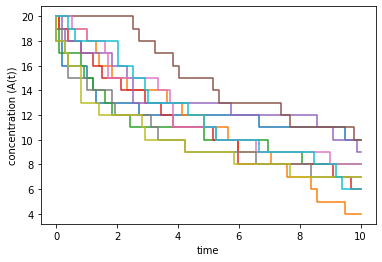

In [29]:
np.random.seed(4)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 100)

for i in range(10):
    values = model.simulate(real_parameters, times)

    # Create an object with links to the model and time series
    problem = pints.SingleOutputProblem(model, times, values)

    # Create a uniform prior parameter
    log_prior = pints.UniformLogPrior([0.0], [0.3])

    # Set the error measure to be used to compare simulated to observed data
    error_measure = pints.RootMeanSquaredError(problem)

    plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

## Fit using Rejection ABC

The rejection ABC method can be used to perform parameter inference for stochastic models, where the likelihood is intractable. In ABC methods, typically, a distance metric comparing the observed data and the simulated is used. Here, we use the root mean square error (RMSE), and we accept a parameter value if the $RMSE<1$.

In [30]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(1)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     31     0.0322580645     0:00.0
2     83     0.0240963855     0:00.1
3     98     0.0306122449     0:00.1
20    1218   0.0164203612     0:00.6
40    2772   0.0144300144     0:01.4
60    4067   0.0147528891     0:02.1
80    5454   0.0146681335     0:02.8
100   8148   0.0122729504     0:04.1
120   9092   0.0131984162     0:04.5
140   10455  0.0133907221     0:05.3
160   11968  0.013368984      0:06.1
180   13143  0.0136955033     0:06.6
200   15315  0.0130590924     0:07.5
220   16561  0.013284222      0:08.2
240   17537  0.013685351      0:08.6
260   18989  0.0136921376     0:09.2
280   20544  0.0136292835     0:09.8
300   21773  0.013778533      0:10.4
320   23146  0.013825283      0:11.0
340   24366  0.0139538701     0:11.4
360   25759  0.0139756978     0:12.0
380   27225  0.0139577594     0:12.6
400   28804  0.0138869601     0:13.4
420   30384  0.0138230648     0:14.0
440   32153  0.0

We now plot the ABC posterior samples versus the actual value that was used to generate the data. This shows that, in this case, the parameter could be identified given the data.

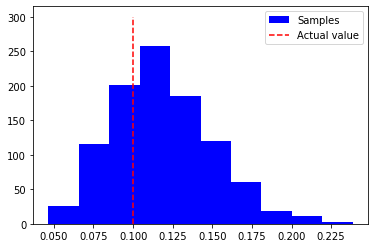

In [31]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
plt.legend()
plt.show()

# Using parallel

In [32]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(1)

# set target number of samples
abc.set_n_samples(1000)

# enable parallelisation
abc.set_parallel(True)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in parallel with 8 worker processess.
Iter. Eval. Acceptance rate Time m:s
1     72     0.0138888889     0:01.6
2     88     0.0227272727     0:01.7
3     96     0.03125          0:01.7
20    1384   0.0151734104     0:04.2
40    3296   0.0124393204     0:08.2
60    4600   0.0132608696     0:11.8
80    7504   0.0111940299     0:18.0
100   9448   0.0111134632     0:22.6
120   10928  0.0114385066     0:25.6
140   13208  0.0112053301     0:31.2
160   14456  0.0116214721     0:33.7
180   16176  0.0116839763     0:37.7
200   17552  0.0119074749     0:40.8
220   18432  0.0124782986     0:42.5
240   20144  0.0124602859     0:46.5
260   21984  0.0125090975     0:50.5
280   23464  0.0126150699     0:53.8
300   25272  0.0125039569     0:58.1
320   26496  0.012718901      1:00.5
340   28328  0.012637673      1:05.0
360   30072  0.0126030859     1:08.8
380   32136  0.0124782176     1:13.9
400   33976  0.0124205321     1:18.0
420   35280  0.0125566893     1:21.

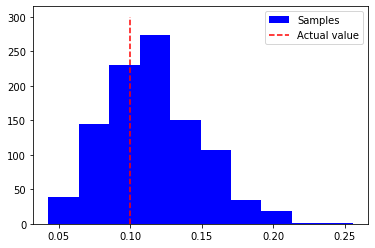

In [33]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
plt.legend()
plt.show()